In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# !rm -rf ./data

## loading data

In [4]:
BATCH_SIZE = 128

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                      transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Resize(227),
                                                torchvision.transforms.Normalize(
                                                  (0.1307,), (0.3081,))]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                     transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Resize(227),
                                                torchvision.transforms.Normalize(
                                                  (0.1307,), (0.3081,))]))

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [14]:
len(trainloader)

469

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


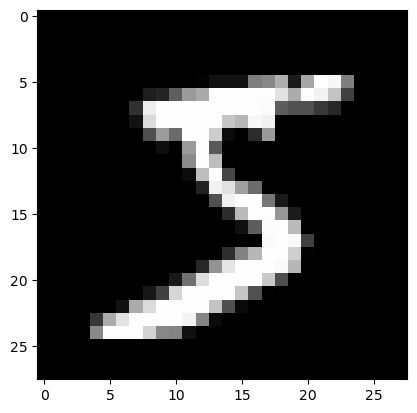

In [6]:
numpy_img = trainloader.dataset.train_data[0].numpy()
plt.imshow(numpy_img, cmap='gray')

## model

In [8]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [10]:
LEARNING_RATE = 0.00015
EPOCHS = 20

In [11]:
model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## train and test functions

In [19]:
train_losses=[]
train_accu=[]

def train(epoch):
    print('\nEpoch : %d'%epoch)

    model.train()

    running_loss=0
    correct=0
    total=0
    
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch.to(device))
        loss = criterion(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
                              
        running_loss += loss.item()
        
        labels = y_batch.to(device)
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

#         if i % 40 == 39:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 40))
#             train_losses.append(running_loss / 40)
#             running_loss = 0.0
#             accu = 100. * correct / total
#             train_accu.append(accu)
             
                              
    train_loss = running_loss / len(trainloader)
    accu = 100. * correct / total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [20]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(testloader)):
            X_batch, y_batch = batch
            
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            
            running_loss += loss.item()
            
            labels = y_batch.to(device)
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
#             if i % 10 == 9:
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 10))
#                 eval_losses.append(running_loss / 10)
#                 running_loss = 0.0
#                 accu = 100. * correct / total
#                 eval_accu.append(accu)
            
    test_loss=running_loss/len(testloader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

## selecting batch size and learning rate

### batch size 64, lr 0.0001

In [54]:
#batch size 64, lr 0.0001
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.853


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.036 | Accuracy: 99.250

Epoch : 2


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.923


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.040 | Accuracy: 99.320

Epoch : 3


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.855


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.390

Epoch : 4


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.900


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 99.370

Epoch : 5


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.878


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.430

Epoch : 6


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.905


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.045 | Accuracy: 99.190

Epoch : 7


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.902


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.420

Epoch : 8


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.923


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.047 | Accuracy: 99.380

Epoch : 9


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.887


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.033 | Accuracy: 99.430

Epoch : 10


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.925


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.034 | Accuracy: 99.380

Epoch : 11


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.905


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.037 | Accuracy: 99.430

Epoch : 12


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.912


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.037 | Accuracy: 99.330

Epoch : 13


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.002 | Accuracy: 99.952


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.052 | Accuracy: 99.270

Epoch : 14


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.912


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.031 | Accuracy: 99.440

Epoch : 15


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.908


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.041 | Accuracy: 99.340

Epoch : 16


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.932


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.036 | Accuracy: 99.280

Epoch : 17


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.002 | Accuracy: 99.958


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.040 | Accuracy: 99.430

Epoch : 18


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.868


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.044 | Accuracy: 99.230

Epoch : 19


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.893


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.042 | Accuracy: 99.260

Epoch : 20


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.001 | Accuracy: 99.957


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.050 | Accuracy: 99.390


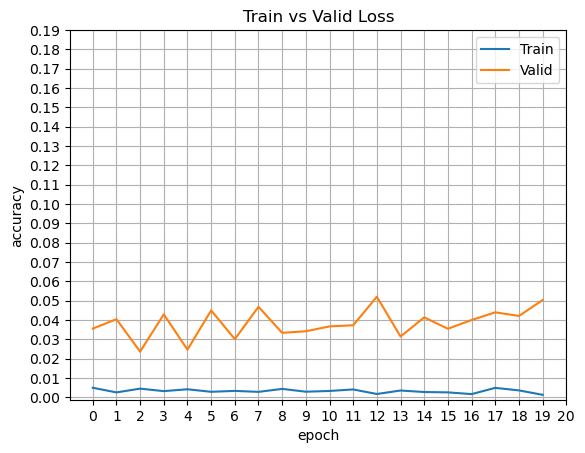

In [63]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0.0, 0.2, 0.01))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

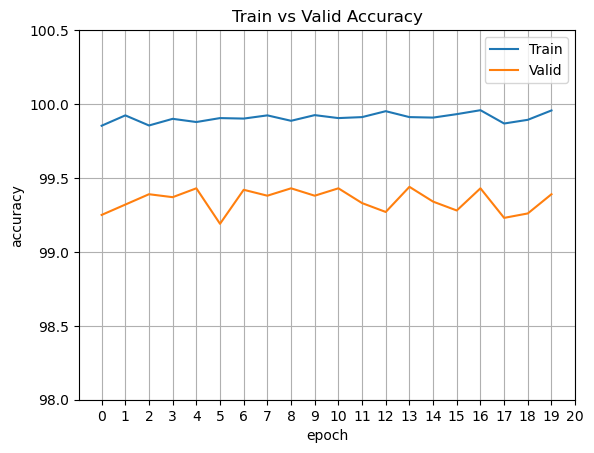

In [62]:
plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(98, 101, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

### batch size 64, lr 0.001

In [64]:
#batch size 64, lr 0.001
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.253 | Accuracy: 91.873


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.087 | Accuracy: 97.410

Epoch : 2


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.081 | Accuracy: 97.733


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.088 | Accuracy: 97.430

Epoch : 3


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.073 | Accuracy: 98.022


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.051 | Accuracy: 98.460

Epoch : 4


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.062 | Accuracy: 98.313


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.137 | Accuracy: 95.970

Epoch : 5


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.063 | Accuracy: 98.303


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.083 | Accuracy: 98.160

Epoch : 6


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.055 | Accuracy: 98.602


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 98.760

Epoch : 7


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.062 | Accuracy: 98.383


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.069 | Accuracy: 98.110

Epoch : 8


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.058 | Accuracy: 98.552


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.048 | Accuracy: 98.830

Epoch : 9


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.044 | Accuracy: 98.830


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.058 | Accuracy: 98.570

Epoch : 10


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.058 | Accuracy: 98.565


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 98.770

Epoch : 11


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.044 | Accuracy: 98.830


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.046 | Accuracy: 98.890

Epoch : 12


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.043 | Accuracy: 98.915


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.055 | Accuracy: 98.680

Epoch : 13


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.046 | Accuracy: 98.790


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.074 | Accuracy: 98.160

Epoch : 14


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.047 | Accuracy: 98.805


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.052 | Accuracy: 98.600

Epoch : 15


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.043 | Accuracy: 98.890


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.072 | Accuracy: 98.030

Epoch : 16


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.034 | Accuracy: 99.135


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 98.920

Epoch : 17


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.038 | Accuracy: 99.047


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.050 | Accuracy: 98.890

Epoch : 18


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 99.065


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.055 | Accuracy: 98.590

Epoch : 19


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.039 | Accuracy: 99.013


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.044 | Accuracy: 99.060

Epoch : 20


  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 99.107


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.051 | Accuracy: 98.970


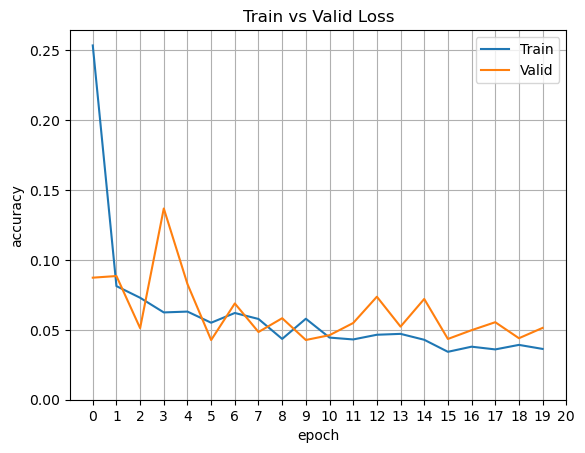

In [70]:
plt.plot(train_losses[20:])
plt.plot(eval_losses[20:])
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0.0, 0.3, 0.05))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

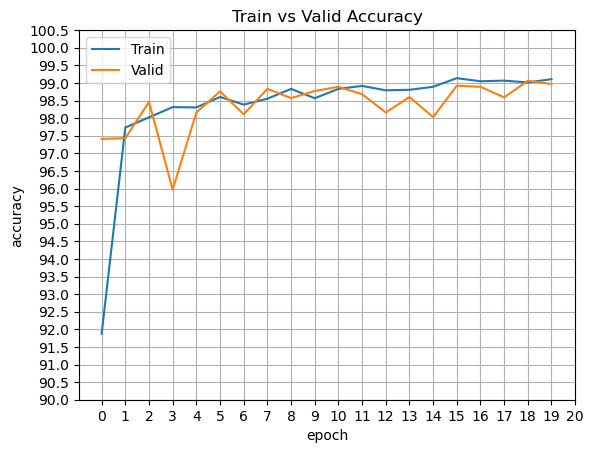

In [68]:
plt.plot(train_accu[20:])
plt.plot(eval_accu[20:])
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(90, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

### batch size 128, lr 0.001

In [14]:
#batch size 128, lr 0.001
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.322 | Accuracy: 90.357


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.065 | Accuracy: 97.980

Epoch : 2


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.068 | Accuracy: 98.013


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.050 | Accuracy: 98.420

Epoch : 3


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.059 | Accuracy: 98.273


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.039 | Accuracy: 98.900

Epoch : 4


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.052 | Accuracy: 98.492


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.034 | Accuracy: 99.000

Epoch : 5


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.041 | Accuracy: 98.803


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.045 | Accuracy: 98.780

Epoch : 6


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.043 | Accuracy: 98.772


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.050 | Accuracy: 98.710

Epoch : 7


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.047 | Accuracy: 98.660


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.054 | Accuracy: 98.460

Epoch : 8


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.041 | Accuracy: 98.872


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.037 | Accuracy: 99.020

Epoch : 9


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 99.003


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.046 | Accuracy: 98.820

Epoch : 10


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 99.020


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.045 | Accuracy: 98.820

Epoch : 11


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 98.983


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.040 | Accuracy: 98.910

Epoch : 12


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.033 | Accuracy: 99.088


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.042 | Accuracy: 99.030

Epoch : 13


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.033 | Accuracy: 99.135


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.042 | Accuracy: 99.000

Epoch : 14


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.036 | Accuracy: 99.027


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.046 | Accuracy: 98.770

Epoch : 15


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.027 | Accuracy: 99.273


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.045 | Accuracy: 99.060

Epoch : 16


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.035 | Accuracy: 99.058


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.049 | Accuracy: 98.960

Epoch : 17


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.028 | Accuracy: 99.212


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 99.020

Epoch : 18


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.030 | Accuracy: 99.247


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.057 | Accuracy: 98.600

Epoch : 19


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.028 | Accuracy: 99.268


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.051 | Accuracy: 98.880

Epoch : 20


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.028 | Accuracy: 99.272


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.054 | Accuracy: 98.560


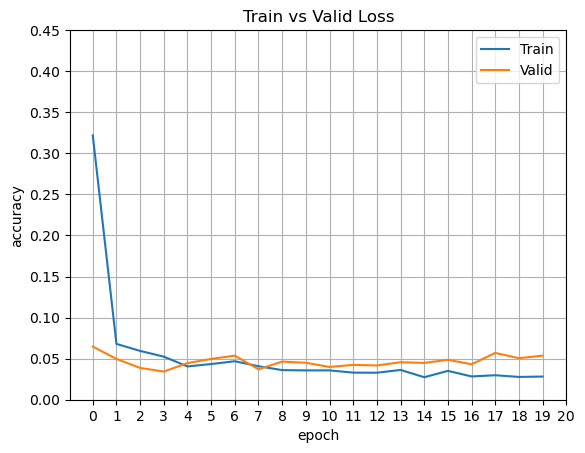

In [19]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0.0, 0.5, 0.05))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

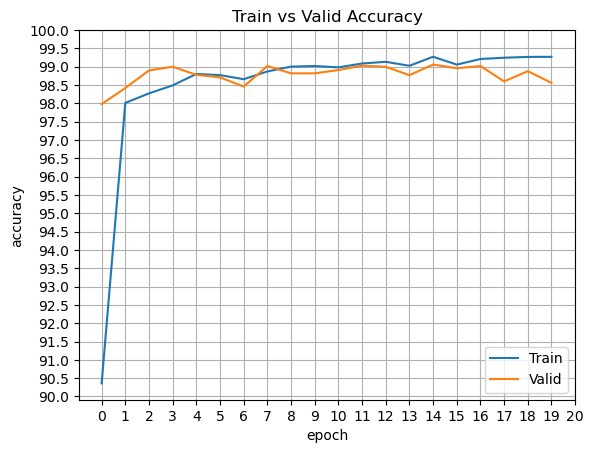

In [20]:
plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(90, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

### batch size 128, lr 0.0001

In [23]:
#batch size 128, lr 0.0001
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.017 | Accuracy: 99.455


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.120

Epoch : 2


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.015 | Accuracy: 99.582


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.300

Epoch : 3


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.012 | Accuracy: 99.622


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.022 | Accuracy: 99.340

Epoch : 4


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.011 | Accuracy: 99.643


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.019 | Accuracy: 99.390

Epoch : 5


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.010 | Accuracy: 99.695


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.021 | Accuracy: 99.440

Epoch : 6


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.740


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.350

Epoch : 7


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.010 | Accuracy: 99.687


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.018 | Accuracy: 99.420

Epoch : 8


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.808


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.480

Epoch : 9


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.007 | Accuracy: 99.792


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.035 | Accuracy: 99.160

Epoch : 10


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.803


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.530

Epoch : 11


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.835


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.330

Epoch : 12


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.798


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.430

Epoch : 13


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.795


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.440

Epoch : 14


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.872


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.029 | Accuracy: 99.350

Epoch : 15


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.847


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.370

Epoch : 16


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.852


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.420

Epoch : 17


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.860


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.035 | Accuracy: 99.420

Epoch : 18


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.860


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.032 | Accuracy: 99.320

Epoch : 19


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.893


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.470

Epoch : 20


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.872


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.036 | Accuracy: 99.260


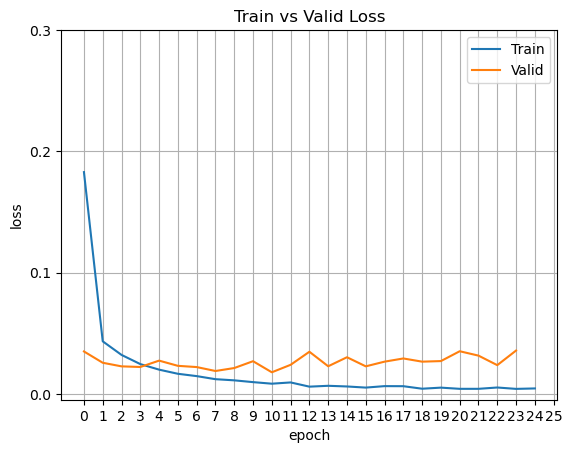

In [27]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 26, 1))
plt.yticks(np.arange(0.0, 0.4, 0.1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

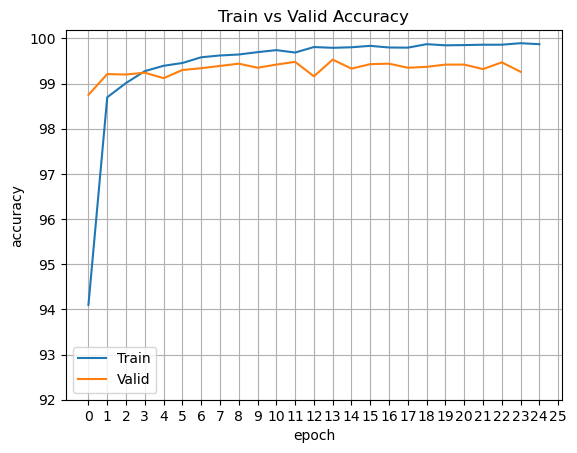

In [28]:
plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 26, 1))
plt.yticks(np.arange(92, 101, 1))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

### batch size 128, lr 0.0002

In [25]:
#batch size 128, lr 0.0002
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.176 | Accuracy: 94.248


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.046 | Accuracy: 98.470

Epoch : 2


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.043 | Accuracy: 98.707


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.032 | Accuracy: 98.960

Epoch : 3


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.033 | Accuracy: 98.980


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.250

Epoch : 4


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.026 | Accuracy: 99.227


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.032 | Accuracy: 98.960

Epoch : 5


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.022 | Accuracy: 99.338


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.029 | Accuracy: 99.120

Epoch : 6


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.018 | Accuracy: 99.437


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.200

Epoch : 7


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.016 | Accuracy: 99.545


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.021 | Accuracy: 99.310

Epoch : 8


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.014 | Accuracy: 99.567


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.320

Epoch : 9


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.012 | Accuracy: 99.610


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.240

Epoch : 10


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.012 | Accuracy: 99.615


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.022 | Accuracy: 99.310

Epoch : 11


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.009 | Accuracy: 99.735


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.037 | Accuracy: 99.030

Epoch : 12


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.009 | Accuracy: 99.720


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.350

Epoch : 13


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.755


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.029 | Accuracy: 99.360

Epoch : 14


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.737


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.270

Epoch : 15


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.743


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.450

Epoch : 16


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.802


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.330

Epoch : 17


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.840


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.026 | Accuracy: 99.370

Epoch : 18


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.810


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.028 | Accuracy: 99.300

Epoch : 19


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.007 | Accuracy: 99.807


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.280

Epoch : 20


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.863


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.380

Epoch : 21


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.915


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.033 | Accuracy: 99.430

Epoch : 22


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.850


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.035 | Accuracy: 99.390

Epoch : 23


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.007 | Accuracy: 99.805


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.035 | Accuracy: 99.340

Epoch : 24


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.833


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.350

Epoch : 25


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.892


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.034 | Accuracy: 99.440


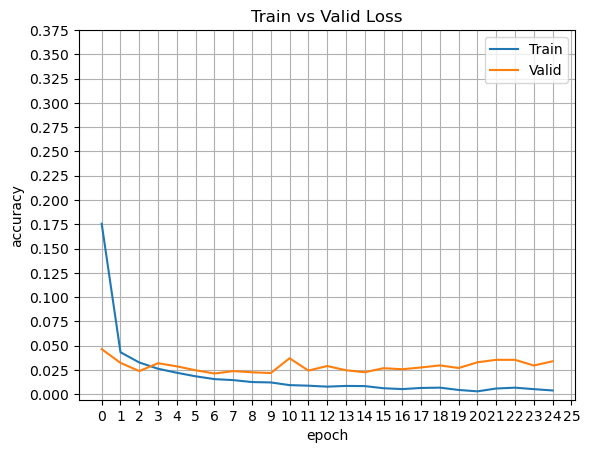

In [31]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 26, 1))
plt.yticks(np.arange(0.0, 0.4, 0.025))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

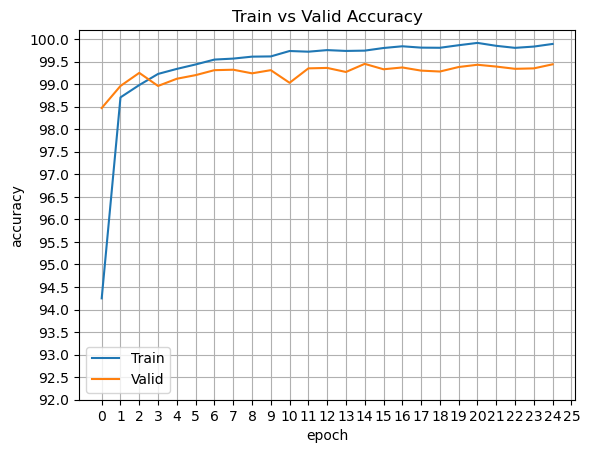

In [29]:
plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 26, 1))
plt.yticks(np.arange(92, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

In [36]:
#batch size 128, lr 0.00015
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.183 | Accuracy: 94.053


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.043 | Accuracy: 98.600

Epoch : 2


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.044 | Accuracy: 98.627


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.028 | Accuracy: 99.170

Epoch : 3


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.032 | Accuracy: 99.043


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.180

Epoch : 4


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.024 | Accuracy: 99.295


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.330

Epoch : 5


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.020 | Accuracy: 99.397


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.022 | Accuracy: 99.310

Epoch : 6


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.017 | Accuracy: 99.457


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.017 | Accuracy: 99.470

Epoch : 7


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.015 | Accuracy: 99.497


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.110

Epoch : 8


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.013 | Accuracy: 99.585


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.340

Epoch : 9


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.012 | Accuracy: 99.600


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.029 | Accuracy: 99.150

Epoch : 10


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.010 | Accuracy: 99.690


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.024 | Accuracy: 99.360

Epoch : 11


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.011 | Accuracy: 99.653


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.020 | Accuracy: 99.540

Epoch : 12


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.010 | Accuracy: 99.698


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.390

Epoch : 13


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.007 | Accuracy: 99.782


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.380

Epoch : 14


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.765


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.021 | Accuracy: 99.410

Epoch : 15


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.008 | Accuracy: 99.755


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.350

Epoch : 16


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.823


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.021 | Accuracy: 99.460

Epoch : 17


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.815


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.026 | Accuracy: 99.340

Epoch : 18


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.820


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.041 | Accuracy: 99.250

Epoch : 19


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.840


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.440

Epoch : 20


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.917


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.027 | Accuracy: 99.480

Epoch : 21


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.835


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.025 | Accuracy: 99.390

Epoch : 22


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.873


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.023 | Accuracy: 99.480

Epoch : 23


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.877


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.380

Epoch : 24


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.006 | Accuracy: 99.833


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.039 | Accuracy: 99.230

Epoch : 25


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.860


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.029 | Accuracy: 99.340

Epoch : 26


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.878


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.028 | Accuracy: 99.360

Epoch : 27


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.002 | Accuracy: 99.935


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.033 | Accuracy: 99.360

Epoch : 28


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.003 | Accuracy: 99.908


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.030 | Accuracy: 99.440

Epoch : 29


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.004 | Accuracy: 99.878


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.034 | Accuracy: 99.360

Epoch : 30


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.005 | Accuracy: 99.852


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.031 | Accuracy: 99.420


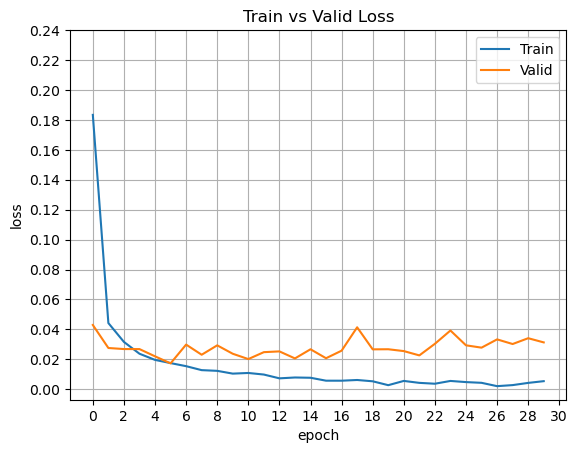

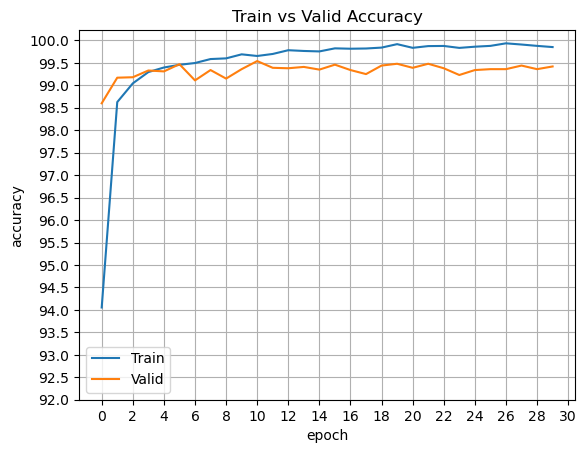

In [34]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 31, 2))
plt.yticks(np.arange(0.0, 0.25, 0.02))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 31, 2))
plt.yticks(np.arange(92, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

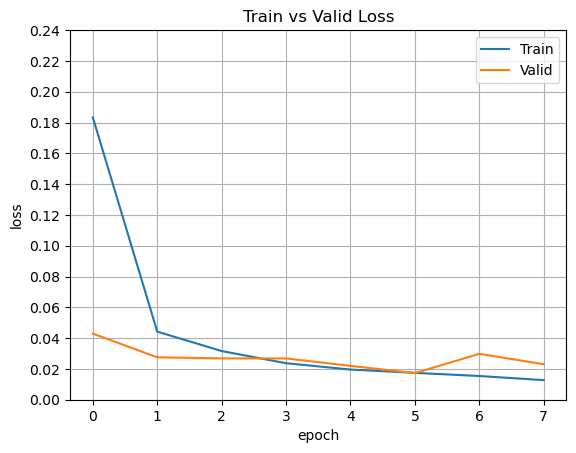

In [25]:
plt.plot(train_losses[:8])
plt.plot(eval_losses[:8])
plt.xticks(np.arange(0, 8, 1))
plt.yticks(np.arange(0.0, 0.25, 0.02))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

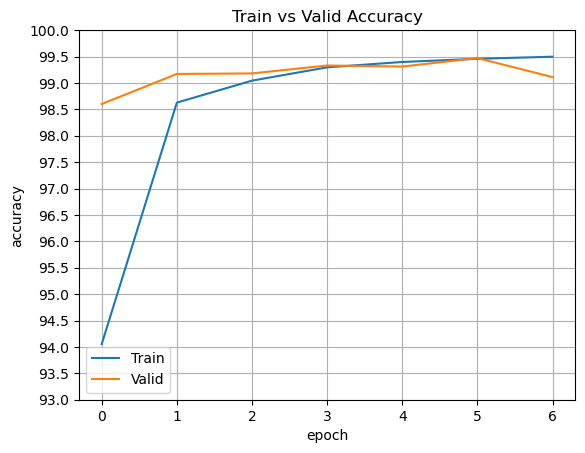

In [24]:
plt.plot(train_accu[:7])
plt.plot(eval_accu[:7])
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 7, 1))
plt.yticks(np.arange(93, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()